In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from google.colab import drive


from keras.utils.vis_utils import plot_model
from PIL import Image

In [ ]:
dir = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Função para achar as imagens no diretorio do drive categoriza-las com as labels certas e aplicar um shape com o tamanho certo para entrar na CNN
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label) 
        class_num = labels.index(label) #pegando o index da pasta (0 e 1) para categoriza-los
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/banco_de_imagens/Bancoimagens/train')
test = get_training_data('/content/drive/MyDrive/banco_de_imagens/Bancoimagens/test')
val = get_training_data('/content/drive/MyDrive/banco_de_imagens/Bancoimagens/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
# dividir os sets no X e Y preditorios. Y se contem ou não pneumonia
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalizando os dados numa escala  de cinzaz de 0 a 255
x_train = np.array(x_train) / 255
x_val = np.array(x_val) /255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning. "1" para imagens em cinza 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
#pré-processamento que realiza colocando imagens na horizontal, dando zoom, compactando e alargando para evitar o overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
image_size = x_train.shape[1]
input_shape = (image_size, image_size, 1)


img_input = tf.keras.Input(shape=input_shape)

#block 1
conv_1 = tf.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(150, 150, 1))(img_input)
norm_1 = tf.keras.layers.BatchNormalization()(conv_1)
maxpool_1 = tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same')(norm_1)

#block 2
conv_2 = tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(maxpool_1)
drop_1 = tf.keras.layers.Dropout(0.1)(conv_2)
norm_2 = tf.keras.layers.BatchNormalization()(drop_1)
maxpool_2 = tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same')(norm_2)

#block 3
conv_3 = tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(maxpool_2)
norm_3 = tf.keras.layers.BatchNormalization()(conv_3)
maxpool_3 = tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same')(norm_3)

#block 4
conv_4 = tf.keras.layers.Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu')(maxpool_3)
drop_2 = tf.keras.layers.Dropout(0.2)(conv_4)
norm_4 = tf.keras.layers.BatchNormalization()(drop_2)
maxpool_4 = tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same')(norm_4)

#block 5
conv_5 = tf.keras.layers.Conv2D(256,(3,3), strides = 1 , padding = 'same' , activation = 'relu')(maxpool_4)
drop_3 = tf.keras.layers.Dropout(0.2)(conv_5)
norm_5 = tf.keras.layers.BatchNormalization()(drop_3)
maxpool_5 = tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same')(norm_5)

#block 6
flatten = Flatten()(maxpool_5)

#Block 7
dense_1 = Dense(128, activation='relu')(flatten)
drop_3 = tf.keras.layers.Dropout(0.2)(dense_1)

#block 8
output = Dense(1, activation='sigmoid')(drop_3)

model = keras.Model(inputs=img_input, outputs=output)
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 374s 2s/step - loss: 0.4775 - accuracy: 0.8475 - val_loss: 29.1238 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
164/164 [==============================] - 354s 2s/step - loss: 0.2488 - accuracy: 0.9024 - val_loss: 58.3575 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9112
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 [==============================] - 357s 2s/step - loss: 0.2479 - accuracy: 0.9112 - val_loss: 51.9899 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
164/164 [==============================] - 355s 2s/step - loss: 0.1653 - accuracy: 0.9447 - val_loss: 4.9310 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/12
164/164 [==============================] - 353s 2s/step - loss: 0.1293 - accuracy: 0.9550 - val_loss: 10.0009 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
164/164 [===========================

Text(0, 0.5, 'Loss')

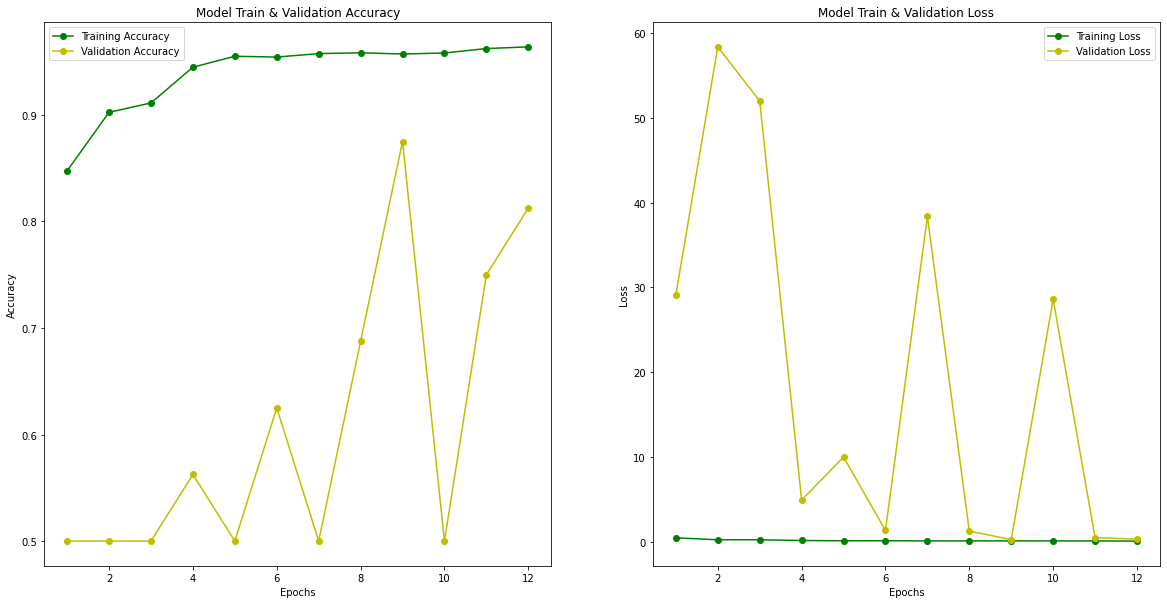

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

14/14 [==============================] - 6s 411ms/step - loss: 0.3712 - accuracy: 0.8774


In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0] # o [0] irá transformar em uma quantidade de 0 a 19 e não em um só
predictions

20/20 [==============================] - 9s 462ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
np.array(labels)[predictions]

array(['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA',
       'PNEUMONI

In [ ]:
len(predictions)

19

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.86      0.90       390
   Normal (Class 1)       0.79      0.91      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.87       624
       weighted avg       0.88      0.88      0.88       624



In [ ]:
matrix = confusion_matrix(y_test,predictions)
matrix

array([[335,  55],
       [ 22, 212]])

In [ ]:
model.save_weights('treino_cnn')

In [ ]:
model.save('xray_container')

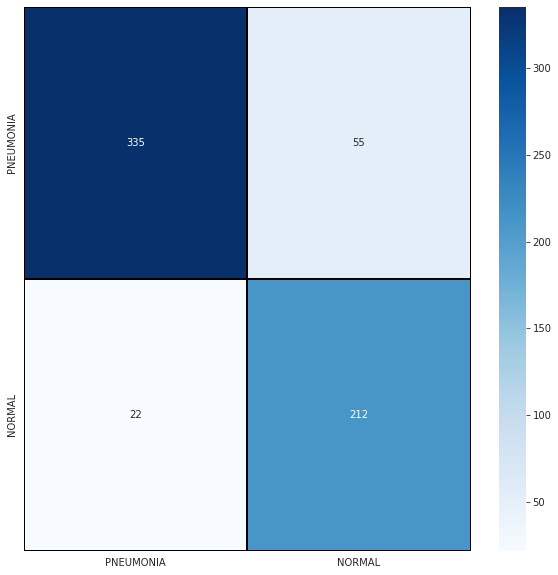

In [ ]:
matrix = pd.DataFrame(matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

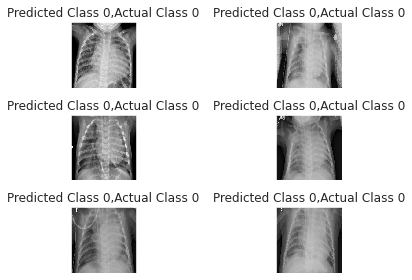

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

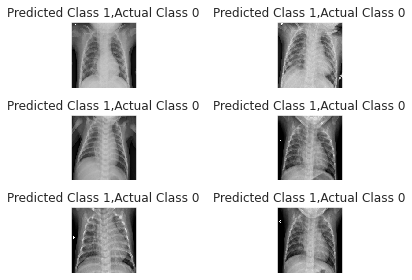

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1